# Setup

In [1]:
n_cores = 16

In [2]:
# isort: off
import os

num_threads = str(n_cores)

# these need to be set prior to numpy import
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

import numpy as np

# isort: on

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from dendritic_cells.config import paper_context
from IPython.display import Markdown, display
from pandas.api.types import CategoricalDtype

import mouse_hema_meth.utils as ut

In [3]:
import dendritic_cells.analyses_for_manuscript_20201015_lib as lib

reloaded


In [4]:
results_dir = "/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt"
os.makedirs(results_dir, exist_ok=True)

In [5]:
def link_fn(s, markdown=True):
    s = str(s)
    curry_path = s.replace(
        "/icgc/dkfzlsdf/analysis/hs_ontogeny/",
        "https://currywurst.dkfz.de/hs-ontogeny/",
    )
    if markdown:
        link = f'[{curry_path}]({curry_path} "will only work within the DKFZ network")'
        # noinspection PyTypeChecker
        display(Markdown(link))
    else:
        print(curry_path)

In [6]:
%matplotlib inline

# Retrieve and format input data

Get cluster ids and dmr boundaries to TSV format, load into python, adjust column names and convert Chromosome to string categorical

In [7]:
cluster_ids_rds = results_dir + "/nW05rWZyjo0wFEVK.rds"
cluster_ids_tsv = results_dir + "/nW05rWZyjo0wFEVK.tsv"
cluster_ids_rds

'/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/nW05rWZyjo0wFEVK.rds'

In [8]:
cluster_ids_beta_values_dmr_coords = pd.read_csv(cluster_ids_tsv, sep="\t")

In [9]:
chrom_dtype = CategoricalDtype(
    np.sort(np.arange(1, 20).astype(str)),
    ordered=True,
)
chrom_dtype

CategoricalDtype(categories=['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '3', '4', '5', '6', '7', '8', '9'],
                 ordered=True)

In [10]:
cluster_ids_beta_values_dmr_coords["chr"] = (
    cluster_ids_beta_values_dmr_coords["chr"].astype(str).astype(chrom_dtype)
)

In [11]:
cluster_ids_beta_values_dmr_coords = (
    cluster_ids_beta_values_dmr_coords.rename(
        columns={"chr": "Chromosome", "start": "Start", "end": "End"}
    )
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
    .rename_axis(index="region_id")
)

In [12]:
cluster_ids_beta_values_dmr_coords

,Chromosome,Start,End,hsc,cdp,cmop,dc_cd11b,dc_cd8a,mono,mdp,pdc,cluster
region_id,,,,,,,,,,,,
0,1,4617581,4617808,0.32,0.89,0.88,0.81,0.91,0.91,0.90,0.92,9
1,1,4623081,4623184,0.03,0.59,0.60,0.55,0.54,0.59,0.63,0.54,9
2,1,5076336,5076640,0.77,0.34,0.35,0.31,0.22,0.40,0.31,0.10,5
3,1,6263050,6263210,0.90,0.82,0.79,0.62,0.53,0.83,0.85,0.35,3
4,1,6454102,6454429,0.71,0.25,0.21,0.27,0.38,0.40,0.32,0.31,4
...,...,...,...,...,...,...,...,...,...,...,...,...
49596,9,124090237,124091149,0.89,0.77,0.72,0.49,0.33,0.43,0.90,0.74,1
49597,9,124101863,124104273,0.89,0.35,0.19,0.46,0.37,0.16,0.32,0.66,4
49598,9,124121334,124122358,0.71,0.25,0.25,0.13,0.14,0.37,0.39,0.18,2


In [13]:
dmrs = cluster_ids_beta_values_dmr_coords[["Chromosome", "Start", "End"]]
dmrs

,Chromosome,Start,End
region_id,,,
0,1,4617581,4617808
1,1,4623081,4623184
2,1,5076336,5076640
3,1,6263050,6263210
4,1,6454102,6454429
...,...,...,...
49596,9,124090237,124091149
49597,9,124101863,124104273
49598,9,124121334,124122358


In [14]:
cluster_ids_df = cluster_ids_beta_values_dmr_coords[["cluster"]]
cluster_ids_df

,cluster
region_id,
0,9
1,9
2,5
3,3
4,4
...,...
49596,1
49597,4
49598,2


# Gene annotation

## Computation

In [15]:
gtf_fp = (
    "/icgc/dkfzlsdf/analysis/hs_ontogeny/databases/gene_annotations"
    "/gencode.vM19.annotation.no-prefix.gtf"
)

In [16]:
anno_res_paths_d = lib.run_gtfanno(
    granges_df=dmrs,
    gtf_fp=gtf_fp,
    output_trunk_path=results_dir + "/dmr-gene-annos",
    promoter_def=(-5000, 1000),
    distant_cis_regulatory_domain_def=(-50000, -5000),
    recompute=True,
)

preparing query bed
Calling gtfanno.annotate
updated 2020-10-19
Loading data
Annotating promoter regions
Annotating transcript parts
UTR classification
Merge results
Classify annotations
Add intergenic regions
Save results
Basic stats for primary annotations
    #Primary annotations  Frequency
0                      1      41535
1                      2       5567
2                      3       1565
3                      4        572
4                      5        222
5                      6         74
6                      7         29
7                      8         16
8                      9         11
9                     12          3
10                    11          3
11                    14          2
12                    13          2
      Feature  Frequency
0      intron      22327
1        DCRD      18293
2    Promoter      15109
3  intergenic       3519
4        exon       1517
5      3'-UTR        963
6      5'-UTR         31
7  transcript          0


## Paths to detailed annotations

In [17]:
anno_res_paths_d

{'primary_annos_bed': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.bed',
 'primary_annos_p': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.p',
 'all_annos_bed': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.bed',
 'all_annos_p': '/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.p'}

In [18]:
for k, v in anno_res_paths_d.items():
    print(k)
    link_fn(v)

primary_annos_bed


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.bed](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.bed "will only work within the DKFZ network")

primary_annos_p


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.p](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_primary-annotations.p "will only work within the DKFZ network")

all_annos_bed


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.bed](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.bed "will only work within the DKFZ network")

all_annos_p


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.p](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr-gene-annos_all-annotations.p "will only work within the DKFZ network")

## Paths to merged annotations

One row per DMR, one feature class per DMR (one of promoter, exon, etc.)

In [19]:
merged_annos = lib.merge_annos(
    gtfanno_result_fp=anno_res_paths_d["primary_annos_p"],
    grange_and_feature_ids=dmrs,
)
merged_annos.to_pickle(results_dir + "/merged-gene-annos.p")
merged_annos.to_csv(results_dir + "/merged-gene-annos.tsv", sep="\t", index=False)

In [20]:
merged_annos

,Chromosome,Start,End,gene_name,feat_class
region_id,,,,,
0,1,4617581,4617808,Gm37323,DCRD
1,1,4623081,4623184,Gm37323,DCRD
2,1,5076336,5076640,Atp6v1h,intron
3,1,6263050,6263210,Rb1cc1,Promoter
4,1,6454102,6454429,"St18,Gm19026",DCRD
...,...,...,...,...,...
49596,9,124090237,124091149,"Ccr5,Ccr2",DCRD
49597,9,124101863,124104273,Ccr2,Promoter
49598,9,124121334,124122358,Ccr5,Promoter


In [21]:
print(results_dir + "/merged-gene-annos.p")
print(results_dir + "/merged-gene-annos.tsv")
link_fn(results_dir + "/merged-gene-annos.tsv")

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.p
/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/merged-gene-annos.tsv "will only work within the DKFZ network")

## Genomic regions quick viz

note about UTRs: i double checked the UTR calling; and I have set 5'-UTR precedence higher than promoters, so this is not an effect of covering 5'-UTRs with promoters. The picture is very similar to global hematopoiesis in general.

<AxesSubplot:>

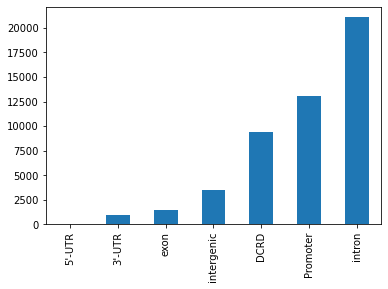

In [22]:
merged_annos['feat_class'].value_counts().sort_values().plot.bar()

# Geneset enrichment

## Geneset inspection (readme!)

**Note1**
There are duplicates within the genesets; beware of this in other analyses too!

**Note2**
The cardinality of the genesets is in part quite high; it may be beneficial for the analysis or the interpretation of the analysis if this is repeated with more curated genelists. Such as it is, each cluster has a high number of gene overlaps, which may be more difficult to interprete. (See section at the end of the notebook)

**Note3**
A considerable number of genes occurs in multiple clusters; is this intended?

In [23]:
dc_genesets_csv = (
    "/home/kraemers/projects/dendritic_cells/local/genesets/concat_genesets.csv"
)

In [24]:
rosenbauer_genesets_df = pd.read_csv(dc_genesets_csv, sep="\t", header=0)

### Geneset contains duplicates (link to cleaned genesets at the end)

The genelists contain multiple mentions of the same genes, this has to be corrected and should be relayed back to the Rosenbauer lab, since this could also affect other analyses, if these genelists would be used elsewherejf.
Number of mentions of unique genes per main geneset (eg 20 genes in coeff4_down are mentioned twice)

In [25]:
rosenbauer_genesets_df.apply(
    lambda ser: ser.dropna().str.upper().value_counts().value_counts(), axis=0
)

,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,672.00,740.00,592.00,871.00,463.00,742,115.00,177.00,71.00,15.00,...,40.00,67.00,78.00,13.00,7.00,45.00,54.00,108.00,38.00,104.00
2,20.00,7.00,19.00,22.00,7.00,19,2.00,2.00,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1.00,2.00,nan,4.00,1.00,2,1.00,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,1.00,1.00,nan,1,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,2.00,nan,1.00,nan,nan,1,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


coeff4_down detailed

In [26]:
with pd.option_context("display.min_rows", 200):
    # pd.options.display.max_rows=200
    display(
        rosenbauer_genesets_df["coeff4_down"]
        .value_counts()
        .to_frame("frequency")
        .query("frequency > 1")
    )

,frequency
Scd2,6
mmu-mir-466b-1,6
mmu-mir-466c-1,3
Bgn,2
Twsg1,2
Ltf,2
Dusp6,2
Hba-a1,2
Cxcr2,2
Alox5,2


remove duplicates

In [27]:
rosenbauer_genesets_no_duplicates = rosenbauer_genesets_df.mask(
    rosenbauer_genesets_df.apply(
        lambda ser: ser.str.upper().duplicated(keep="first"), axis=0
    )
)

verify

In [28]:
rosenbauer_genesets_no_duplicates.apply(
    lambda ser: ser.dropna().str.upper().value_counts().value_counts(), axis=0
)

,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,695,749,613,898,471,765,118,179,71,15,...,40,67,78,13,7,45,54,108,38,104


In [29]:
rosenbauer_genesets_no_duplicates

,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
0,Car1,Phf12,Dntt,Atg3,Dntt,Trappc10,Klk8,Kif9,Wdr6,Vcam1,...,Mmp9,Gys1,Pafah1b3,Vcam1,Sdc1,Scarb1,Scd2,Nmt1,Satb1,Glrx
1,Cpa3,Gatm,Car1,Srd5a3,Il7r,Prtn3,Bex4,Olfr1009,Ly6a,Irf8,...,Ier5,Rps6ka2,Dpp4,Pld3,Plxnb2,Ctsc,Casp6,Anxa6,Mov10,Gys1
2,Pf4,Commd8,Ahsp,Sf3b5,Hist1h3d,Eif3g,Ncam1,3110057O12Rik,Ccnd1,Slc39a8,...,Egln3,Rsph1,Fyn,Laptm4b,Camk2d,Gstm1,Tmem109,Suclg1,Ulk1,Klc4
3,Ahsp,n-R5s159,Tspan13,Atp6v1b2,Cmah,Fgd6,Ctsf,Phyhd1,Tgm2,Itpr3,...,Ngp,Hnmt,Slc15a2,Hebp1,Olfm1,Smpdl3a,Rps15,Gm2a,Phf1,Tuba4a
4,Car2,Fuca2,Prg2,LOC101055658,Igh-VJ558,Mapk3,Hspa1a,Lgalsl,Fyn,Icosl,...,Prok2,Pygl,Rgs1,Pdia5,Fam129b,Soat1,Sepw1,Vac14,Ier5,Grina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,NaN,NaN,NaN,Far2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
927,NaN,NaN,NaN,Trem3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
928,NaN,NaN,NaN,Sgms2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,NaN,NaN,NaN,1810033B17Rik,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
rosenbauer_genesets_no_duplicates_tsv = (
    results_dir + "/rosenbauer-genesets_no-duplicates.tsv"
)
rosenbauer_genesets_no_duplicates.to_csv(
    rosenbauer_genesets_no_duplicates_tsv, sep="\t"
)

In [31]:
print(rosenbauer_genesets_no_duplicates_tsv)
link_fn(rosenbauer_genesets_no_duplicates_tsv)

/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/rosenbauer-genesets_no-duplicates.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/rosenbauer-genesets_no-duplicates.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/rosenbauer-genesets_no-duplicates.tsv "will only work within the DKFZ network")

### Genesets are large

Number of unique genes

In [32]:
rosenbauer_genesets_no_duplicates.stack().nunique()

2939

<AxesSubplot:>

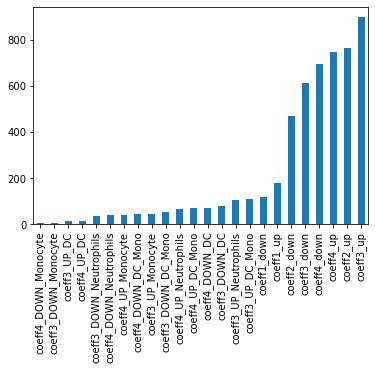

In [33]:
rosenbauer_genesets_no_duplicates.notnull().sum().sort_values().plot.bar()

### Genes occur in multiple clusters

Example: just the non cell type specific clusters

In [34]:
n_cluster_per_gene = (
    rosenbauer_genesets_no_duplicates
    # filter for non cell type specific genesets
    .filter(regex=r"(down|up)$")
    .stack()
    .value_counts()
    .sort_values(ascending=False)
)

Histogram of #clusters per gene

<AxesSubplot:>

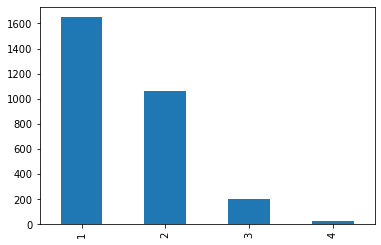

In [35]:
n_cluster_per_gene.value_counts().plot.bar()

In [36]:
with pd.option_context("display.min_rows", 50, "display.max_rows", 50):
    display(n_cluster_per_gene.head(30))

Siglecg          4
Gstm4            4
Emp1             4
Fcgr3            4
Epb4.1l4b        4
Fnbp1l           4
Rps6ka2          4
Mc5r             4
Myadml2          4
Mira             4
Swsap1           4
H2-Q9            4
n-R5s40          4
Bmx              4
Retsat           4
Snx7             4
Tcrb-J           4
AB124611         4
Lgalsl           4
Mtus1            4
1700012B09Rik    4
Alyref           4
Il22ra2          4
Flt3             4
Serpinb10        4
Scnn1a           4
Gm20695          4
Mfsd2b           3
LOC101055658     3
Nucb2            3
dtype: int64

## Computation (Report with figures at the end of the section)

In [37]:
dmr_geneset_enrichments_output_dir = results_dir + "/dmr_geneset_enrichments_results"
dmr_geneset_enrichments_report_dir = (
    results_dir + "/dmr_geneset_enrichments_results/report"
)
# os.makedirs(dmr_geneset_enrichments_report_dir, exist_ok=True)

In [38]:
geneset_databases_d = lib.create_gmt_for_rosenbauer_genesets(
    rosenbauer_genesets_no_duplicates
)
geneset_databases_d

{'rosenbauer_genesets_all_gmt': '/home/kraemers/projects/dendritic_cells/local/genesets/rosenbauer_all.gmt',
 'rosenbauer_genesets_coeff12_only_gmt': '/home/kraemers/projects/dendritic_cells/local/genesets/rosenbauer_coeff12.gmt'}

In [39]:
for fp in geneset_databases_d.values():
    assert os.path.exists(fp)

currently need to clean output dir because all results there will be in report

In [40]:
lib.run_geneset_enrichment_analysis(
    merged_gene_annos=merged_annos,
    cluster_ids=cluster_ids_df,
    geneset_databases_d=geneset_databases_d,
    output_dir=dmr_geneset_enrichments_output_dir,
    report_dir=dmr_geneset_enrichments_report_dir,
    max_pvalues=(0.05, 1),
    barcode_plot_args_d=dict(
        col_width_cm=0.5,
        row_height_cm=0.1,
        linewidth=0.5,
        vmin_quantile=0.05,
        divergent_cmap="RdYlGn_r",
        cluster_features=True,
    ),
    feature_annos=dmrs,
    n_cores=n_cores,
    recompute=True,
    filters=["promoter", "gene_regions", "all_annotated"],
    additional_formats=("pdf", "svg"),
    # vlim=(-5, 5),
)

Generate report
Report:  /icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/report/marker_gene_enrichments.html


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/report/marker_gene_enrichments.html](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/report/marker_gene_enrichments.html "will only work within the DKFZ network")

## Overlap counts, overlapping genes

In [41]:
overlap_stats_pattern = (
    dmr_geneset_enrichments_output_dir + "/{anno_name}/{database}/overlap-stats.p"
)
cluster_overlap_stats_pattern = (
    dmr_geneset_enrichments_output_dir
    + "/{anno_name}/{database}/{clustering}.{filter}/cluster-overlap-stats.p"
)

### Table: dmrs vs hit in geneset (boolean)

In [42]:
hits_table = (overlap_stats_pattern[:-2] + "_hits.p").format(
    anno_name="gtfanno", database="rosenbauer_genesets_all_gmt"
)
hits_table_df = pd.read_pickle(hits_table)
display(hits_table_df.query("coeff1_up == 1").head())

coeff4_down  coeff4_up  coeff3_down  coeff3_up  \
Chromosome Start    End                                                        
1          40250767 40251197            1          0            1          0   
           40252620 40252696            1          0            1          0   
           40262378 40262980            1          0            1          0   
           40263634 40263742            1          0            1          0   
           40267283 40267485            1          0            1          0   

                              coeff2_down  coeff2_up  coeff1_down  coeff1_up  \
Chromosome Start    End                                                        
1          40250767 40251197            0          0            0          1   
           40252620 40252696            0          0            0          1   
           40262378 40262980            0          0            0          1   
           40263634 40263742            0          0            0          1   
           40267283 40267485            0          0            0          1   

                              coeff4_DOWN_DC  coeff4_UP_DC  ...  \
Chromosome Start    End                                     ...   
1          40250767 40251197               0             0  ...   
           40252620 40252696               0             0  ...   
           40262378 40262980               0             0  ...   
           40263634 40263742               0             0  ...   
           40267283 40267485               0             0  ...   

                              coeff4_DOWN_Neutrophils  coeff4_UP_Neutrophils  \
Chromosome Start    End                                                        
1          40250767 40251197                        0                      0   
           40252620 40252696                        0                      0   
           40262378 40262980                        0                      0   
           40263634 40263742                        0                      0   
           40267283 40267485                        0                      0   

                              coeff3_DOWN_DC  coeff3_UP_DC  \
Chromosome Start    End                                      
1          40250767 40251197               0             0   
           40252620 40252696               0             0   
           40262378 40262980               0             0   
           40263634 40263742               0             0   
           40267283 40267485               0             0   

                              coeff3_DOWN_Monocyte  coeff3_UP_Monocyte  \
Chromosome Start    End                                                  
1          40250767 40251197                     0                   0   
           40252620 40252696                     0                   0   
           40262378 40262980                     0                   0   
           40263634 40263742                     0                   0   
           40267283 40267485                     0                   0   

                              coeff3_DOWN_DC_Mono  coeff3_UP_DC_Mono  \
Chromosome Start    End                                                
1          40250767 40251197                    0                  0   
           40252620 40252696                    0                  0   
           40262378 40262980                    0                  0   
           40263634 40263742                    0                  0   
           40267283 40267485                    0                  0   

                              coeff3_DOWN_Neutrophils  coeff3_UP_Neutrophils  
Chromosome Start    End                                                       
1          40250767 40251197                        0                      0  
           40252620 40252696                        0                      0  
           40262378 40262980                        0                      0  
           40263634 402

In [43]:
hits_table_tsv = hits_table.replace("_hits.p", "_hits.tsv")
hits_table_df.to_csv(hits_table_tsv, sep="\t", index=True)
hits_table_tsv
link_fn(hits_table_tsv)

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/overlap-stats_hits.tsv "will only work within the DKFZ network")

### Tables: clusters vs number of hits in cluster

**Note** the caveats on the provided genesets (see above)

Note that one gene is often hit by several DMRs, eg some DCRD, and hits in the promoter, introns etc.

In [44]:
cluster_sizes = cluster_ids_df["cluster"].value_counts()
cluster_sizes.sort_values()

9    3377
8    3914
7    4103
6    4428
5    5005
4    6247
3    7171
2    7429
1    7927
Name: cluster, dtype: int64

In [45]:
cluster_overlap_counts_by_filter_tsv = (
    cluster_overlap_stats_pattern.format(
        anno_name="gtfanno",
        database="rosenbauer_genesets_all_gmt",
        clustering="cluster",
        filter="{filter}",
    )[:-2]
    + "_hits.tsv"
)
for filter_name in ["promoter", "gene_regions", "all_annotated"]:
    curr_cluster_overlap_counts_tsv = cluster_overlap_counts_by_filter_tsv.format(
        filter=filter_name
    )
    print(filter_name)
    print("Total # Hits")
    overlap_counts = pd.read_csv(curr_cluster_overlap_counts_tsv, sep="\t").set_axis(
        np.arange(1, 10)
    )
    display(overlap_counts)
    print("% Hits")
    display(
        overlap_counts.divide(
            cluster_sizes, axis=0
        ) * 100,
    )
    print(curr_cluster_overlap_counts_tsv)
    link_fn(curr_cluster_overlap_counts_tsv)

promoter
Total # Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,39,115,41,119,32,67,5,15,11,4,...,5,12,11,0,1,10,7,17,5,17
2,64,67,75,78,43,72,3,12,14,1,...,5,11,15,2,2,2,10,8,4,22
3,59,64,68,59,45,47,3,8,17,5,...,1,2,13,3,1,0,15,19,5,5
4,48,77,53,101,18,88,4,10,11,0,...,6,14,10,2,0,6,8,7,3,19
5,28,31,47,50,31,33,3,6,11,2,...,1,0,12,1,1,0,10,11,2,6
6,18,76,23,107,16,80,4,19,1,2,...,1,12,3,2,2,9,3,9,3,23
7,27,33,22,35,24,33,2,3,9,1,...,2,1,8,1,0,3,7,9,0,2
8,16,34,25,26,19,15,4,1,5,4,...,1,3,5,1,0,1,11,5,1,3
9,57,22,49,32,13,57,3,14,8,1,...,3,4,4,2,0,3,7,3,3,9


% Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,0.49,1.45,0.52,1.50,0.40,0.85,0.06,0.19,0.14,0.05,...,0.06,0.15,0.14,0.00,0.01,0.13,0.09,0.21,0.06,0.21
2,0.86,0.90,1.01,1.05,0.58,0.97,0.04,0.16,0.19,0.01,...,0.07,0.15,0.20,0.03,0.03,0.03,0.13,0.11,0.05,0.30
3,0.82,0.89,0.95,0.82,0.63,0.66,0.04,0.11,0.24,0.07,...,0.01,0.03,0.18,0.04,0.01,0.00,0.21,0.26,0.07,0.07
4,0.77,1.23,0.85,1.62,0.29,1.41,0.06,0.16,0.18,0.00,...,0.10,0.22,0.16,0.03,0.00,0.10,0.13,0.11,0.05,0.30
5,0.56,0.62,0.94,1.00,0.62,0.66,0.06,0.12,0.22,0.04,...,0.02,0.00,0.24,0.02,0.02,0.00,0.20,0.22,0.04,0.12
6,0.41,1.72,0.52,2.42,0.36,1.81,0.09,0.43,0.02,0.05,...,0.02,0.27,0.07,0.05,0.05,0.20,0.07,0.20,0.07,0.52
7,0.66,0.80,0.54,0.85,0.58,0.80,0.05,0.07,0.22,0.02,...,0.05,0.02,0.19,0.02,0.00,0.07,0.17,0.22,0.00,0.05
8,0.41,0.87,0.64,0.66,0.49,0.38,0.10,0.03,0.13,0.10,...,0.03,0.08,0.13,0.03,0.00,0.03,0.28,0.13,0.03,0.08
9,1.69,0.65,1.45,0.95,0.38,1.69,0.09,0.41,0.24,0.03,...,0.09,0.12,0.12,0.06,0.00,0.09,0.21,0.09,0.09,0.27


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.promoter/cluster-overlap-stats_hits.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.promoter/cluster-overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.promoter/cluster-overlap-stats_hits.tsv "will only work within the DKFZ network")

gene_regions
Total # Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,178,315,188,336,130,242,26,42,34,8,...,14,28,40,6,5,51,47,30,17,47
2,201,203,228,249,133,210,18,40,46,6,...,25,30,59,6,4,14,35,20,19,62
3,189,240,228,216,174,182,21,25,52,11,...,10,23,49,6,4,17,53,37,15,32
4,207,248,201,294,100,228,20,34,37,4,...,29,39,45,9,4,40,34,15,20,54
5,122,139,159,175,103,123,10,20,49,6,...,7,8,54,3,3,7,34,22,10,21
6,94,260,110,327,71,213,16,37,16,6,...,9,41,23,5,4,32,14,21,10,65
7,112,123,125,143,94,116,20,14,31,4,...,4,8,41,3,2,17,40,25,4,15
8,100,131,98,133,70,100,24,12,26,12,...,7,17,28,7,0,16,31,17,4,23
9,178,74,181,103,59,156,10,23,32,2,...,14,9,26,4,6,7,36,12,16,17


% Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,2.25,3.97,2.37,4.24,1.64,3.05,0.33,0.53,0.43,0.10,...,0.18,0.35,0.50,0.08,0.06,0.64,0.59,0.38,0.21,0.59
2,2.71,2.73,3.07,3.35,1.79,2.83,0.24,0.54,0.62,0.08,...,0.34,0.40,0.79,0.08,0.05,0.19,0.47,0.27,0.26,0.83
3,2.64,3.35,3.18,3.01,2.43,2.54,0.29,0.35,0.73,0.15,...,0.14,0.32,0.68,0.08,0.06,0.24,0.74,0.52,0.21,0.45
4,3.31,3.97,3.22,4.71,1.60,3.65,0.32,0.54,0.59,0.06,...,0.46,0.62,0.72,0.14,0.06,0.64,0.54,0.24,0.32,0.86
5,2.44,2.78,3.18,3.50,2.06,2.46,0.20,0.40,0.98,0.12,...,0.14,0.16,1.08,0.06,0.06,0.14,0.68,0.44,0.20,0.42
6,2.12,5.87,2.48,7.38,1.60,4.81,0.36,0.84,0.36,0.14,...,0.20,0.93,0.52,0.11,0.09,0.72,0.32,0.47,0.23,1.47
7,2.73,3.00,3.05,3.49,2.29,2.83,0.49,0.34,0.76,0.10,...,0.10,0.19,1.00,0.07,0.05,0.41,0.97,0.61,0.10,0.37
8,2.55,3.35,2.50,3.40,1.79,2.55,0.61,0.31,0.66,0.31,...,0.18,0.43,0.72,0.18,0.00,0.41,0.79,0.43,0.10,0.59
9,5.27,2.19,5.36,3.05,1.75,4.62,0.30,0.68,0.95,0.06,...,0.41,0.27,0.77,0.12,0.18,0.21,1.07,0.36,0.47,0.50


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.gene_regions/cluster-overlap-stats_hits.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.gene_regions/cluster-overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.gene_regions/cluster-overlap-stats_hits.tsv "will only work within the DKFZ network")

all_annotated
Total # Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,191,342,204,378,136,271,27,46,36,8,...,18,30,42,7,5,57,53,32,21,54
2,226,235,268,276,152,226,20,48,50,7,...,26,37,66,6,5,14,46,25,20,68
3,206,262,252,234,186,191,22,30,54,11,...,12,24,51,6,4,17,57,43,17,33
4,226,270,221,319,110,249,22,41,39,4,...,32,44,47,9,5,43,39,20,22,58
5,130,148,175,184,114,129,11,25,49,6,...,7,10,58,3,3,7,38,24,10,23
6,104,274,116,352,73,224,17,38,16,6,...,10,47,23,5,5,33,14,21,10,71
7,126,127,134,150,97,123,22,14,32,4,...,5,9,41,3,2,17,43,28,4,17
8,107,136,109,142,74,106,26,12,27,12,...,9,17,32,10,0,16,34,19,6,23
9,186,81,189,109,60,164,11,24,34,2,...,14,10,28,4,6,7,37,13,16,19


% Hits


,coeff4_down,coeff4_up,coeff3_down,coeff3_up,coeff2_down,coeff2_up,coeff1_down,coeff1_up,coeff4_DOWN_DC,coeff4_UP_DC,...,coeff4_DOWN_Neutrophils,coeff4_UP_Neutrophils,coeff3_DOWN_DC,coeff3_UP_DC,coeff3_DOWN_Monocyte,coeff3_UP_Monocyte,coeff3_DOWN_DC_Mono,coeff3_UP_DC_Mono,coeff3_DOWN_Neutrophils,coeff3_UP_Neutrophils
1,2.41,4.31,2.57,4.77,1.72,3.42,0.34,0.58,0.45,0.10,...,0.23,0.38,0.53,0.09,0.06,0.72,0.67,0.40,0.26,0.68
2,3.04,3.16,3.61,3.72,2.05,3.04,0.27,0.65,0.67,0.09,...,0.35,0.50,0.89,0.08,0.07,0.19,0.62,0.34,0.27,0.92
3,2.87,3.65,3.51,3.26,2.59,2.66,0.31,0.42,0.75,0.15,...,0.17,0.33,0.71,0.08,0.06,0.24,0.79,0.60,0.24,0.46
4,3.62,4.32,3.54,5.11,1.76,3.99,0.35,0.66,0.62,0.06,...,0.51,0.70,0.75,0.14,0.08,0.69,0.62,0.32,0.35,0.93
5,2.60,2.96,3.50,3.68,2.28,2.58,0.22,0.50,0.98,0.12,...,0.14,0.20,1.16,0.06,0.06,0.14,0.76,0.48,0.20,0.46
6,2.35,6.19,2.62,7.95,1.65,5.06,0.38,0.86,0.36,0.14,...,0.23,1.06,0.52,0.11,0.11,0.75,0.32,0.47,0.23,1.60
7,3.07,3.10,3.27,3.66,2.36,3.00,0.54,0.34,0.78,0.10,...,0.12,0.22,1.00,0.07,0.05,0.41,1.05,0.68,0.10,0.41
8,2.73,3.47,2.78,3.63,1.89,2.71,0.66,0.31,0.69,0.31,...,0.23,0.43,0.82,0.26,0.00,0.41,0.87,0.49,0.15,0.59
9,5.51,2.40,5.60,3.23,1.78,4.86,0.33,0.71,1.01,0.06,...,0.41,0.30,0.83,0.12,0.18,0.21,1.10,0.38,0.47,0.56


/icgc/dkfzlsdf/analysis/hs_ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.all_annotated/cluster-overlap-stats_hits.tsv


[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.all_annotated/cluster-overlap-stats_hits.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/dmr_geneset_enrichments_results/gtfanno/rosenbauer_genesets_all_gmt/cluster.all_annotated/cluster-overlap-stats_hits.tsv "will only work within the DKFZ network")

### Annotation: clusters vs marker genes found

Genes found in clusters, filtered by gene body, promoter, or all regions

In [46]:
dc_genesets_csv = (
    "/home/kraemers/projects/dendritic_cells/local/genesets/concat_genesets.csv"
)
genesets_d_ser = {}
genesets_d_ser["rosenbauer_all"] = pd.read_csv(
    dc_genesets_csv, sep="\t", header=0
).T.agg(lambda ser: ser.str.upper().dropna().tolist(), axis=1)
genesets_d_ser["rosenbauer_coeff1and2"] = pd.read_csv(
    dc_genesets_csv,
    usecols=["coeff1_up", "coeff1_down", "coeff2_up", "coeff2_down"],
    sep="\t",
    header=0,
).T.agg(lambda ser: ser.str.upper().dropna().tolist(), axis=1)

In [89]:
cluster_marker_genes_df = lib.cluster_marker_genes_overview(
    genesets_d_ser=genesets_d_ser,
    primary_gene_annos=pd.read_pickle(anno_res_paths_d["primary_annos_p"]),
    granges_df=cluster_ids_beta_values_dmr_coords,
    cluster_ids=cluster_ids_df,
)
cluster_marker_genes_df.head()

,geneset_database_name,genomic_regions,geneset_name,cluster_id,gene_name
0,rosenbauer_all,promoter,coeff4_down,1,"[ASB2, ATP8B5, BLVRB, CBR1, CUEDC1, CYTH3, CYTH3, DAPP1, DPYSL2, EEF2K, ELL2, GM13203, GM13686, GM16225, GM16225, HRH2, IFITM1, ITGAX, LRRC8C, LRRC8C, LTF, LTF, MMP14, NEDD4, P2RY14, P2RY14, PLEKHO2, PPP1R9B, RGL1, SLC14A1, SLC14A1, SLC23A2, SLC23A2, SLC7A8, ST3GAL5, TCF4, TGM2, TLR12, TSC22D1, TSC22D1, TSPAN14, UBE2S, VPS37B]"
1,rosenbauer_all,promoter,coeff4_down,2,"[2900026A02RIK, 9030619P08RIK, AF067061, ALOX5, BCL11A, BCL11A, CD4, CD7, CD96, CLIP2, CTR9, CTR9, CTR9, CTTN, CTTN, CTTN, CYP11A1, CYP11A1, CYP11A1, DNMT3A, DUSP6, EYA2, F2RL3, FAM129B, FAM53C, FLT3, FUT7, GALNT6, GCNT2, GFI1B, GM16225, IL1R1, IL1R1, ITGAX, JAKMIP1, JAKMIP1, JAKMIP1, LGALS9, LPCAT2, LTF, MAP4K4, MC5R, MDGA1, MMP8, MYL10, NEDD4, NEURL3, NLRC3, NLRC3, P2RY14, PLEK, PLEK, PTPN3, RBPMS2, RCOR2, RGS1, RHD, RIN2, RYK, SLAMF1, SLC22A3, SORBS3, SYNPO2, TAP2, TAP2, TAP2, TAP2, TCF4, TCF4, TCF4, TCF4, TGFBR2, TGFBR3, THSD1, TSPAN13, TXNIP, VAMP5, ZG16]"
2,rosenbauer_all,promoter,coeff4_down,3,"[ACSS1, ASB2, ASB2, ASB2, BCL11A, CASP6, CBFA2T3, CBLB, CBLB, CD7, CLNK, CTNNA1, D630045J12RIK, DHX37, DIRAS2, DNMT3A, EMP1, FABP4, FAM129B, FAM32A, GM1965, GRIK5, H2-AA, IGHM, IGHM, IL1RL1, ISLR, ITGAX, ITGAX, ITGAX, JAKMIP1, JAKMIP1, JAKMIP1, LMNA, LMNA, LMNA, MAP4K4, MAP4K4, MNS1, NEDD4, NLRC3, PAK4, PDCD1, PTPN3, RGL1, RNASE6, RNASE6, SERPINB10, SLC22A23, SLC23A2, SLC23A2, SORBS3, ST6GAL1, SYDE2, TAP2, TFR2, TRIM34A, VPS37B, VPS37B, VPS37B, VPS37B, ZFP362, ZFP362, ZFPM1]"
3,rosenbauer_all,promoter,coeff4_down,4,"[2900026A02RIK, ACSF2, AFF3, AFF3, ALOX5, ANKS1, CD72, CLNK, CPA3, CXCR2, DEXI, EEF2K, EMILIN2, EMILIN2, EMILIN2, FLNB, FYN, GABBR1, GALNT6, GALNT6, GCNT2, GCNT2, GM12827, GM5111, GPR171, IL12RB2, IL1R1, INPP4B, INSL6, KANSL2, LGALS9, LTC4S, LTC4S, MAP7, MAP7, MMP8, MMP8, MUC13, MUC13, MYH10, NXPE2, P2RY14, P2RY14, P2RY14, PDCD1, RAB38, REPIN1, RNF144A, RNF144A, RPS16, RYK, SELP, SERPINB10, SIPA1L1, SORBS3, SYDE2, TCF4, TRIM58, TWSG1]"
4,rosenbauer_all,promoter,coeff4_down,5,"[ACSF2, AHNAK2, CAPN5, CBFA2T3, CBFA2T3, CBFA2T3, CBFA2T3, CD7, CD9, CYP11A1, DDAH2, DHX37, DNTT, DNTT, DNTT, EGFL7, FGFR1, FRMD6, GM16225, GPSM1, GSE1, HEMGN, JAKMIP1, JAKMIP1, JAKMIP1, JAKMIP1, LAT, MAPK4, MNS1, MYLPF, PLCG1, PLCG1, RCOR2, REPIN1, RHD, ST6GAL1, THY1, TRP53I11]"


In [121]:
cluster_marker_genes_tsv = results_dir + "/cluster-marker-genes.tsv"
cluster_marker_genes_df.to_csv(cluster_marker_genes_tsv, sep="\t")
cluster_marker_genes_tsv
link_fn(cluster_marker_genes_tsv)

[https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/cluster-marker-genes.tsv](https://currywurst.dkfz.de/hs-ontogeny/notebook-data/gNs4xcMJscaLLwlt/cluster-marker-genes.tsv "will only work within the DKFZ network")